In [1]:
# === CONFIGURATION ===
# Set the pulsar name here
PULSAR_NAME = "J1909-3744"

# Data paths (modify as needed)
DATA_DIR = "/home/mattm/projects/MPTA/partim/production/fifth_pass/tdb"

# Number of timing iterations for benchmarking
N_BENCHMARK_ITERATIONS = 10

In [2]:
# === IMPORTS AND SETUP ===
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import numpy as np
import jax
import jax.numpy as jnp
import math
import time
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Any, Optional, Tuple
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import EarthLocation, get_body_barycentric_posvel, solar_system_ephemeris
import matplotlib.pyplot as plt

# PINT
from pint.models import get_model as pint_get_model
from pint.toa import get_TOAs as pint_get_TOAs
from pint.residuals import Residuals

jax.config.update('jax_enable_x64', True)
print(f"JAX {jax.__version__}, Float64: {jax.config.jax_enable_x64}")
print(f"JAX devices: {jax.devices()}")

JAX 0.8.1, Float64: True
JAX devices: [CudaDevice(id=0)]


W1128 15:21:01.438427  385598 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1128 15:21:01.439761  385446 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [3]:
# === CONSTANTS ===
SECS_PER_DAY = 86400.0
C_KM_S = 299792.458
T_SUN_SEC = 4.925490947e-6
AU_KM = 149597870.7
K_DM_SEC = 1.0 / 2.41e-4

# Planetary GM/c^3 (seconds)
T_PLANET = {
    'jupiter': 4.702819050227708e-09,
    'saturn':  1.408128810019423e-09,
    'uranus':  2.150589551363761e-10,
    'neptune': 2.537311999186760e-10,
    'venus':   1.205680558494223e-11,
}

# Observatory coordinates (ITRF, km) - MeerKAT default
OBSERVATORIES = {
    'meerkat': np.array([5109360.133, 2006852.586, -3238948.127]) / 1000,
    'parkes': np.array([-4554231.533, 2816759.046, -3454036.323]) / 1000,
    'gbt': np.array([882589.289, -4924872.368, 3943729.418]) / 1000,
}

# High-precision parameters
HIGH_PRECISION_PARAMS = {'F0', 'F1', 'F2', 'F3', 'PEPOCH', 'TZRMJD', 'POSEPOCH', 'DMEPOCH'}

In [4]:
# === PARAMETER PARSING ===

def parse_par_file(path: Path) -> Dict[str, Any]:
    """Parse tempo2-style .par file with high precision for timing-critical parameters."""
    params = {}
    params_str = {}
    
    with open(path) as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            parts = line.split()
            if len(parts) >= 2:
                key = parts[0].upper()
                value_str = parts[1]
                
                if key in HIGH_PRECISION_PARAMS:
                    params_str[key] = value_str
                    try:
                        params[key] = float(value_str)
                    except ValueError:
                        params[key] = value_str
                else:
                    try:
                        params[key] = float(value_str)
                    except ValueError:
                        params[key] = value_str
    
    params['_high_precision'] = params_str
    return params


def get_longdouble(params: Dict, key: str, default: float = None) -> np.longdouble:
    """Get a parameter as np.longdouble with full precision."""
    hp = params.get('_high_precision', {})
    if key in hp:
        return np.longdouble(hp[key])
    elif key in params:
        return np.longdouble(params[key])
    elif default is not None:
        return np.longdouble(default)
    else:
        raise KeyError(f"Parameter {key} not found")


def parse_ra(ra_str: str) -> float:
    """Parse RA string (HH:MM:SS.sss) to radians."""
    parts = ra_str.split(':')
    h, m, s = float(parts[0]), float(parts[1]), float(parts[2])
    return (h + m/60 + s/3600) * 15 * np.pi / 180


def parse_dec(dec_str: str) -> float:
    """Parse DEC string (DD:MM:SS.sss) to radians."""
    parts = dec_str.split(':')
    sign = -1 if parts[0].startswith('-') else 1
    d, m, s = abs(float(parts[0])), float(parts[1]), float(parts[2])
    return sign * (d + m/60 + s/3600) * np.pi / 180

In [5]:
# === ASTROMETRIC AND DELAY FUNCTIONS ===

def compute_ssb_obs_pos_vel(tdb_mjd: np.ndarray, obs_itrf_km: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Compute observatory position and velocity relative to SSB using Astropy/DE440."""
    times = Time(tdb_mjd, format='mjd', scale='tdb')
    
    with solar_system_ephemeris.set('de440'):
        earth_pv = get_body_barycentric_posvel('earth', times)
        ssb_geo_pos = earth_pv[0].xyz.to(u.km).value.T
        ssb_geo_vel = earth_pv[1].xyz.to(u.km/u.s).value.T
    
    obs_itrf = EarthLocation.from_geocentric(
        obs_itrf_km[0] * u.km, obs_itrf_km[1] * u.km, obs_itrf_km[2] * u.km
    )
    
    obs_gcrs = obs_itrf.get_gcrs(obstime=times)
    geo_obs_pos = np.column_stack([
        obs_gcrs.cartesian.x.to(u.km).value,
        obs_gcrs.cartesian.y.to(u.km).value,
        obs_gcrs.cartesian.z.to(u.km).value
    ])
    
    # Observatory velocity from numerical derivative
    dt_sec = 1.0
    times_plus = Time(tdb_mjd + dt_sec/SECS_PER_DAY, format='mjd', scale='tdb')
    obs_gcrs_plus = obs_itrf.get_gcrs(obstime=times_plus)
    geo_obs_pos_plus = np.column_stack([
        obs_gcrs_plus.cartesian.x.to(u.km).value,
        obs_gcrs_plus.cartesian.y.to(u.km).value,
        obs_gcrs_plus.cartesian.z.to(u.km).value
    ])
    geo_obs_vel = (geo_obs_pos_plus - geo_obs_pos) / dt_sec
    
    return ssb_geo_pos + geo_obs_pos, ssb_geo_vel + geo_obs_vel


def compute_pulsar_direction(ra_rad: float, dec_rad: float, pmra_rad_day: float, 
                              pmdec_rad_day: float, posepoch: float, t_mjd: np.ndarray) -> np.ndarray:
    """Compute pulsar direction unit vector with proper motion."""
    dt = t_mjd - posepoch
    cos_dec0 = np.cos(dec_rad)
    ra = ra_rad + pmra_rad_day * dt / cos_dec0
    dec = dec_rad + pmdec_rad_day * dt
    cos_dec = np.cos(dec)
    return np.column_stack([cos_dec * np.cos(ra), cos_dec * np.sin(ra), np.sin(dec)])


def compute_roemer_delay(ssb_obs_pos_km: np.ndarray, L_hat: np.ndarray, 
                         parallax_mas: float = 0.0) -> np.ndarray:
    """Compute Roemer delay including parallax correction."""
    re_dot_L = np.sum(ssb_obs_pos_km * L_hat, axis=1)
    roemer_sec = -re_dot_L / C_KM_S
    
    if parallax_mas != 0.0:
        distance_kpc = 1.0 / parallax_mas
        L_km = distance_kpc * 3.085677581e16
        re_sqr = np.sum(ssb_obs_pos_km**2, axis=1)
        parallax_sec = 0.5 * (re_sqr / L_km) * (1.0 - re_dot_L**2 / re_sqr) / C_KM_S
        roemer_sec = roemer_sec + parallax_sec
    return roemer_sec


def compute_shapiro_delay(obs_body_pos_km: np.ndarray, L_hat: np.ndarray, 
                          T_body: float) -> np.ndarray:
    """Compute Shapiro delay for a body."""
    r = np.sqrt(np.sum(obs_body_pos_km**2, axis=1))
    rcostheta = np.sum(obs_body_pos_km * L_hat, axis=1)
    return -2.0 * T_body * np.log((r - rcostheta) / AU_KM)


def compute_barycentric_freq(freq_topo_mhz: np.ndarray, ssb_obs_vel_km_s: np.ndarray, 
                              L_hat: np.ndarray) -> np.ndarray:
    """Compute barycentric frequency."""
    v_radial = np.sum(ssb_obs_vel_km_s * L_hat, axis=1)
    return freq_topo_mhz * (1.0 - v_radial / C_KM_S)

In [6]:
# === JAX-COMPILED DELAY FUNCTIONS ===

@jax.jit
def dm_delay(t_mjd, freq_mhz, dm_coeffs, dm_factorials, dm_epoch):
    """Compute DM delay with time-varying DM."""
    dt_years = (t_mjd - dm_epoch) / 365.25
    powers = jnp.arange(len(dm_coeffs))
    dt_powers = dt_years[:, jnp.newaxis] ** powers[jnp.newaxis, :]
    dm_eff = jnp.sum(dm_coeffs * dt_powers / dm_factorials, axis=1)
    return K_DM_SEC * dm_eff / (freq_mhz ** 2)


@jax.jit
def solar_wind_delay(obs_sun_pos_km, L_hat, freq_mhz, ne_sw):
    """Compute solar wind dispersion delay."""
    AU_KM_local = 1.495978707e8
    AU_PC = 4.84813681e-6
    r_km = jnp.sqrt(jnp.sum(obs_sun_pos_km**2, axis=1))
    r_au = r_km / AU_KM_local
    sun_dir = obs_sun_pos_km / r_km[:, jnp.newaxis]
    cos_elong = jnp.sum(sun_dir * L_hat, axis=1)
    elong = jnp.arccos(jnp.clip(cos_elong, -1.0, 1.0))
    rho = jnp.pi - elong
    sin_rho = jnp.maximum(jnp.sin(rho), 1e-10)
    geometry_pc = AU_PC * rho / (r_au * sin_rho)
    dm_sw = ne_sw * geometry_pc
    return K_DM_SEC * dm_sw / (freq_mhz ** 2)


@jax.jit
def fd_delay(freq_mhz, fd_coeffs):
    """Compute frequency-dependent delay."""
    log_freq = jnp.log(freq_mhz / 1000.0)
    poly_coeffs = jnp.concatenate([fd_coeffs[::-1], jnp.array([0.0])])
    return jnp.polyval(poly_coeffs, log_freq)


@jax.jit
def ell1_binary_delay(t_tdb, pb, a1, tasc, eps1, eps2, pbdot, xdot, gamma, r_shap, s_shap):
    """ELL1 binary delay with third-order eccentricity and aberration correction."""
    dt_days = t_tdb - tasc
    dt_sec = dt_days * SECS_PER_DAY
    n0 = 2.0 * jnp.pi / (pb * SECS_PER_DAY)
    Phi = n0 * dt_sec * (1.0 - pbdot / 2.0 / pb * dt_days)
    
    sin_Phi, cos_Phi = jnp.sin(Phi), jnp.cos(Phi)
    sin_2Phi, cos_2Phi = jnp.sin(2*Phi), jnp.cos(2*Phi)
    sin_3Phi, cos_3Phi = jnp.sin(3*Phi), jnp.cos(3*Phi)
    sin_4Phi, cos_4Phi = jnp.sin(4*Phi), jnp.cos(4*Phi)
    
    a1_eff = jnp.where(xdot != 0.0, a1 + xdot * dt_sec, a1)
    
    eps1_sq, eps2_sq = eps1**2, eps2**2
    eps1_cu, eps2_cu = eps1**3, eps2**3
    
    # Dre / a1 (third-order Roemer)
    Dre_a1 = (
        sin_Phi + 0.5 * (eps2 * sin_2Phi - eps1 * cos_2Phi)
        - (1.0/8.0) * (5*eps2_sq*sin_Phi - 3*eps2_sq*sin_3Phi - 2*eps2*eps1*cos_Phi
                      + 6*eps2*eps1*cos_3Phi + 3*eps1_sq*sin_Phi + 3*eps1_sq*sin_3Phi)
        - (1.0/12.0) * (5*eps2_cu*sin_2Phi + 3*eps1_sq*eps2*sin_2Phi
                       - 6*eps1*eps2_sq*cos_2Phi - 4*eps1_cu*cos_2Phi
                       - 4*eps2_cu*sin_4Phi + 12*eps1_sq*eps2*sin_4Phi
                       + 12*eps1*eps2_sq*cos_4Phi - 4*eps1_cu*cos_4Phi)
    )
    
    # Drep / a1 (derivative)
    Drep_a1 = (
        cos_Phi + eps1 * sin_2Phi + eps2 * cos_2Phi
        - (1.0/8.0) * (5*eps2_sq*cos_Phi - 9*eps2_sq*cos_3Phi + 2*eps1*eps2*sin_Phi
                      - 18*eps1*eps2*sin_3Phi + 3*eps1_sq*cos_Phi + 9*eps1_sq*cos_3Phi)
        - (1.0/12.0) * (10*eps2_cu*cos_2Phi + 6*eps1_sq*eps2*cos_2Phi
                       + 12*eps1*eps2_sq*sin_2Phi + 8*eps1_cu*sin_2Phi
                       - 16*eps2_cu*cos_4Phi + 48*eps1_sq*eps2*cos_4Phi
                       - 48*eps1*eps2_sq*sin_4Phi + 16*eps1_cu*sin_4Phi)
    )
    
    # Drepp / a1 (second derivative)
    Drepp_a1 = (
        -sin_Phi + 2*eps1*cos_2Phi - 2*eps2*sin_2Phi
        - (1.0/8.0) * (-5*eps2_sq*sin_Phi + 27*eps2_sq*sin_3Phi + 2*eps1*eps2*cos_Phi
                      - 54*eps1*eps2*cos_3Phi - 3*eps1_sq*sin_Phi - 27*eps1_sq*sin_3Phi)
        - (1.0/12.0) * (-20*eps2_cu*sin_2Phi - 12*eps1_sq*eps2*sin_2Phi
                       + 24*eps1*eps2_sq*cos_2Phi + 16*eps1_cu*cos_2Phi
                       + 64*eps2_cu*sin_4Phi - 192*eps1_sq*eps2*sin_4Phi
                       - 192*eps1*eps2_sq*cos_4Phi + 64*eps1_cu*cos_4Phi)
    )
    
    Dre = a1_eff * Dre_a1
    Drep = a1_eff * Drep_a1
    Drepp = a1_eff * Drepp_a1
    
    # Aberration correction (Damour & Deruelle 1986)
    nhat = n0
    delay_roemer = Dre * (1 - nhat*Drep + (nhat*Drep)**2 + 0.5*nhat**2*Dre*Drepp)
    
    delay_einstein = gamma * sin_Phi
    delay_shapiro = jnp.where(
        (r_shap != 0.0) & (s_shap != 0.0),
        -2.0 * r_shap * jnp.log(1.0 - s_shap * sin_Phi),
        0.0
    )
    
    return delay_roemer + delay_einstein + delay_shapiro

In [7]:
# === JUG RESIDUAL CALCULATOR CLASS ===

@dataclass
class JUGResidualCalculator:
    """JUG-based pulsar timing residual calculator."""
    
    par_params: Dict[str, Any]
    pint_model: Any  # For TZR reference
    pint_toas: Any   # For TZR reference
    obs_itrf_km: np.ndarray
    
    # Precomputed arrays (set after initialization)
    ssb_obs_pos_km: np.ndarray = None
    ssb_obs_vel_km_s: np.ndarray = None
    L_hat: np.ndarray = None
    freq_bary_mhz: np.ndarray = None
    obs_sun_pos_km: np.ndarray = None
    times: Any = None
    
    def __post_init__(self):
        """Precompute astrometric quantities."""
        self._precompute_astrometry()
    
    def _precompute_astrometry(self):
        """Precompute SSB positions, pulsar direction, etc."""
        tdbld = np.array(self.pint_toas.table['tdbld'].value, dtype=np.float64)
        freq_mhz = np.array(self.pint_toas.table['freq'].value, dtype=np.float64)
        
        # Astrometric parameters
        ra_rad = parse_ra(self.par_params['RAJ'])
        dec_rad = parse_dec(self.par_params['DECJ'])
        pmra_rad_day = self.par_params.get('PMRA', 0.0) * (np.pi / 180 / 3600000) / 365.25
        pmdec_rad_day = self.par_params.get('PMDEC', 0.0) * (np.pi / 180 / 3600000) / 365.25
        posepoch = self.par_params.get('POSEPOCH', self.par_params['PEPOCH'])
        
        # SSB positions
        self.ssb_obs_pos_km, self.ssb_obs_vel_km_s = compute_ssb_obs_pos_vel(tdbld, self.obs_itrf_km)
        self.L_hat = compute_pulsar_direction(ra_rad, dec_rad, pmra_rad_day, pmdec_rad_day, posepoch, tdbld)
        self.freq_bary_mhz = compute_barycentric_freq(freq_mhz, self.ssb_obs_vel_km_s, self.L_hat)
        
        # Sun position
        self.times = Time(tdbld, format='mjd', scale='tdb')
        with solar_system_ephemeris.set('de440'):
            sun_pos = get_body_barycentric_posvel('sun', self.times)[0].xyz.to(u.km).value.T
        self.obs_sun_pos_km = sun_pos - self.ssb_obs_pos_km
    
    def compute_residuals(self, verbose: bool = False) -> np.ndarray:
        """Compute timing residuals in microseconds."""
        tdbld = np.array(self.pint_toas.table['tdbld'].value, dtype=np.float64)
        parallax_mas = self.par_params.get('PX', 0.0)
        
        # Roemer delay
        roemer_sec = compute_roemer_delay(self.ssb_obs_pos_km, self.L_hat, parallax_mas)
        
        # Sun Shapiro delay
        sun_shapiro_sec = compute_shapiro_delay(self.obs_sun_pos_km, self.L_hat, T_SUN_SEC)
        
        # Planetary Shapiro delays
        planet_shapiro_enabled = str(self.par_params.get('PLANET_SHAPIRO', 'N')).upper() in ('Y', 'YES', 'TRUE', '1')
        if planet_shapiro_enabled:
            planet_shapiro_sec = np.zeros(len(tdbld))
            with solar_system_ephemeris.set('de440'):
                for planet in ['jupiter', 'saturn', 'uranus', 'neptune', 'venus']:
                    planet_pos = get_body_barycentric_posvel(planet, self.times)[0].xyz.to(u.km).value.T
                    obs_planet_km = planet_pos - self.ssb_obs_pos_km
                    planet_shapiro_sec += compute_shapiro_delay(obs_planet_km, self.L_hat, T_PLANET[planet])
            shapiro_sec = sun_shapiro_sec + planet_shapiro_sec
        else:
            shapiro_sec = sun_shapiro_sec
        
        roemer_shapiro_sec = roemer_sec + shapiro_sec
        
        # DM delay
        dm_coeffs = []
        k = 0
        while True:
            key = 'DM' if k == 0 else f'DM{k}'
            if key in self.par_params:
                dm_coeffs.append(float(self.par_params[key]))
                k += 1
            else:
                break
        dm_coeffs = np.array(dm_coeffs if dm_coeffs else [0.0])
        dm_factorials = np.array([float(math.factorial(i)) for i in range(len(dm_coeffs))])
        dm_epoch = float(self.par_params.get('DMEPOCH', self.par_params['PEPOCH']))
        
        dm_sec = np.array(dm_delay(
            jnp.array(tdbld), jnp.array(self.freq_bary_mhz),
            jnp.array(dm_coeffs), jnp.array(dm_factorials), dm_epoch
        ))
        
        # Solar wind delay
        NE_SW = float(self.par_params.get('NE_SW', 0.0))
        if NE_SW > 0:
            sw_sec = np.array(solar_wind_delay(
                jnp.array(self.obs_sun_pos_km), jnp.array(self.L_hat), 
                jnp.array(self.freq_bary_mhz), NE_SW
            ))
        else:
            sw_sec = np.zeros_like(dm_sec)
        
        # FD delay
        fd_coeffs = []
        fd_idx = 1
        while f'FD{fd_idx}' in self.par_params:
            fd_coeffs.append(float(self.par_params[f'FD{fd_idx}']))
            fd_idx += 1
        if fd_coeffs:
            fd_sec = np.array(fd_delay(jnp.array(self.freq_bary_mhz), jnp.array(fd_coeffs)))
        else:
            fd_sec = np.zeros_like(dm_sec)
        
        # Binary delay (ELL1)
        if 'PB' in self.par_params:
            PB = float(self.par_params['PB'])
            A1 = float(self.par_params['A1'])
            TASC = float(self.par_params['TASC'])
            EPS1 = float(self.par_params.get('EPS1', 0.0))
            EPS2 = float(self.par_params.get('EPS2', 0.0))
            PBDOT = float(self.par_params.get('PBDOT', 0.0))
            XDOT = float(self.par_params.get('XDOT', 0.0))
            GAMMA = float(self.par_params.get('GAMMA', 0.0))
            
            M2 = float(self.par_params.get('M2', 0.0))
            SINI = float(self.par_params.get('SINI', 0.0))
            H3 = float(self.par_params.get('H3', 0.0))
            STIG = float(self.par_params.get('STIG', 0.0))
            
            if H3 != 0.0 or STIG != 0.0:
                r_shapiro, s_shapiro = H3, STIG
            elif M2 != 0.0 and SINI != 0.0:
                r_shapiro, s_shapiro = T_SUN_SEC * M2, SINI
            else:
                r_shapiro, s_shapiro = 0.0, 0.0
            
            t_topo_tdb = tdbld - (roemer_shapiro_sec + dm_sec + sw_sec + fd_sec) / SECS_PER_DAY
            binary_sec = np.array(ell1_binary_delay(
                jnp.array(t_topo_tdb), PB, A1, TASC, EPS1, EPS2, PBDOT, XDOT, GAMMA, r_shapiro, s_shapiro
            ))
        else:
            binary_sec = np.zeros_like(dm_sec)
        
        # Total delay
        total_delay_sec = roemer_shapiro_sec + dm_sec + sw_sec + fd_sec + binary_sec
        
        # Phase calculation (longdouble precision)
        PEPOCH = get_longdouble(self.par_params, 'PEPOCH')
        F0 = get_longdouble(self.par_params, 'F0')
        F1 = get_longdouble(self.par_params, 'F1', 0.0)
        F2 = get_longdouble(self.par_params, 'F2', 0.0)
        
        tdbld_ld = np.array(self.pint_toas.table['tdbld'].value, dtype=np.longdouble)
        delay_ld = np.array(total_delay_sec, dtype=np.longdouble)
        dt_sec = (tdbld_ld - PEPOCH) * np.longdouble(SECS_PER_DAY) - delay_ld
        
        phase = F0 * dt_sec + np.longdouble(0.5) * F1 * dt_sec**2 + np.longdouble(1.0/6.0) * F2 * dt_sec**3
        
        # TZR reference (using PINT's TZR)
        pint_tzr_toa = self.pint_model.get_TZR_toa(self.pint_toas)
        TZRMJD_TDB = np.longdouble(pint_tzr_toa.table['tdbld'][0])
        pint_tzr_delay = float(self.pint_model.delay(pint_tzr_toa).to('s').value[0])
        
        tzr_dt_sec = (TZRMJD_TDB - PEPOCH) * np.longdouble(SECS_PER_DAY) - np.longdouble(pint_tzr_delay)
        phase_tzr = F0 * tzr_dt_sec + np.longdouble(0.5) * F1 * tzr_dt_sec**2 + np.longdouble(1.0/6.0) * F2 * tzr_dt_sec**3
        
        # Fractional phase
        frac_phase = phase - phase_tzr
        frac_phase = np.mod(frac_phase + 0.5, 1.0) - 0.5
        
        # Convert to microseconds
        residuals_us = np.array(frac_phase / F0 * 1e6, dtype=np.float64)
        
        if verbose:
            print(f"JUG residuals RMS: {np.std(residuals_us):.3f} µs")
        
        return residuals_us

In [8]:
# === LOAD DATA ===
print("="*70)
print(f"Loading data for {PULSAR_NAME}")
print("="*70)

par_file = Path(DATA_DIR) / f"{PULSAR_NAME}_tdb.par"
tim_file = Path(DATA_DIR) / f"{PULSAR_NAME}.tim"

if not par_file.exists():
    raise FileNotFoundError(f"Par file not found: {par_file}")
if not tim_file.exists():
    raise FileNotFoundError(f"Tim file not found: {tim_file}")

print(f"Par file: {par_file}")
print(f"Tim file: {tim_file}")

# Load with PINT
pint_model = pint_get_model(str(par_file))
pint_toas = pint_get_TOAs(str(tim_file), model=pint_model)
print(f"\nLoaded {pint_toas.ntoas} TOAs for {pint_model.PSR.value}")

# Parse par file with high precision
par_params = parse_par_file(par_file)

# Detect observatory
obs_itrf_km = OBSERVATORIES.get('meerkat')  # Default
print(f"Using MeerKAT observatory coordinates")

/home/mattm/soft/PINT/src/pint/models/model_builder.py:220: UserWarning: Unrecognized parfile line 'EPHVER 5'
  warnings.warn(f"Unrecognized parfile line '{p_line}'", UserWarning)
/home/mattm/soft/PINT/src/pint/models/model_builder.py:220: UserWarning: Unrecognized parfile line 'TNSUBTRACTPOLY 1'
  warnings.warn(f"Unrecognized parfile line '{p_line}'", UserWarning)
/home/mattm/soft/PINT/src/pint/models/model_builder.py:220: UserWarning: Unrecognized parfile line 'DM_SERIES TAYLOR'
  warnings.warn(f"Unrecognized parfile line '{p_line}'", UserWarning)
2025-11-28 15:21:01.510 | DEBUG    | pint.toa:get_TOAs:195 - Using EPHEM = DE440 from the given model
2025-11-28 15:21:01.510 | DEBUG    | pint.toa:get_TOAs:211 - Using CLOCK = BIPM2024 from the given model
2025-11-28 15:21:01.510 | DEBUG    | pint.toa:get_TOAs:232 - Using PLANET_SHAPIRO = True from the given model
2025-11-28 15:21:01.510 | DEBUG    | pint.toa:get_TOAs:211 - Using CLOCK = BIPM2024 from the given model
2025-11-28 15:21:01.51

Loading data for J1909-3744
Par file: /home/mattm/projects/MPTA/partim/production/fifth_pass/tdb/J1909-3744_tdb.par
Tim file: /home/mattm/projects/MPTA/partim/production/fifth_pass/tdb/J1909-3744.tim


2025-11-28 15:21:02.611 | DEBUG    | pint.toa:__init__:1377 - No pulse number flags found in the TOAs
2025-11-28 15:21:02.624 | DEBUG    | pint.toa:apply_clock_corrections:2232 - Applying clock corrections (include_bipm = True)
2025-11-28 15:21:02.624 | DEBUG    | pint.toa:apply_clock_corrections:2232 - Applying clock corrections (include_bipm = True)
2025-11-28 15:21:02.831 | INFO     | pint.observatory:gps_correction:230 - Applying GPS to UTC clock correction (~few nanoseconds)
2025-11-28 15:21:02.832 | DEBUG    | pint.observatory:_load_gps_clock:108 - Loading global GPS clock file
2025-11-28 15:21:02.834 | DEBUG    | pint.observatory.clock_file:__init__:812 - Global clock file gps2utc.clk saving kwargs={'bogus_last_correction': False, 'valid_beyond_ends': False}
2025-11-28 15:21:02.835 | DEBUG    | pint.observatory.clock_file:read_tempo2_clock_file:463 - Loading TEMPO2-format observatory clock correction file gps2utc.clk (/home/mattm/.astropy/cache/download/url/d3c81b5766f4bfb84e655


Loaded 10408 TOAs for J1909-3744
Using MeerKAT observatory coordinates


In [9]:
# === INITIALIZE JUG CALCULATOR ===
print("\nInitializing JUG calculator (precomputing astrometry)...")
t_start = time.perf_counter()

jug_calc = JUGResidualCalculator(
    par_params=par_params,
    pint_model=pint_model,
    pint_toas=pint_toas,
    obs_itrf_km=obs_itrf_km
)

t_init = time.perf_counter() - t_start
print(f"JUG initialization time: {t_init:.3f} s")


Initializing JUG calculator (precomputing astrometry)...
JUG initialization time: 0.586 s
JUG initialization time: 0.586 s


In [10]:
# === WARM-UP JIT COMPILATION ===
print("\nWarming up JIT compilation...")
_ = jug_calc.compute_residuals(verbose=False)
print("JIT compilation complete.")


Warming up JIT compilation...


2025-11-28 15:21:06.303 | DEBUG    | pint.models.absolute_phase:get_TZR_toa:101 - Creating and dealing with the single TZR_toa for absolute phase
2025-11-28 15:21:06.304 | DEBUG    | pint.toa:__init__:1377 - No pulse number flags found in the TOAs
2025-11-28 15:21:06.305 | DEBUG    | pint.toa:apply_clock_corrections:2232 - Applying clock corrections (include_bipm = True)
2025-11-28 15:21:06.305 | INFO     | pint.observatory:gps_correction:230 - Applying GPS to UTC clock correction (~few nanoseconds)
2025-11-28 15:21:06.306 | INFO     | pint.observatory:bipm_correction:245 - Applying TT(TAI) to TT(BIPM2023) clock correction (~27 us)
2025-11-28 15:21:06.306 | INFO     | pint.observatory:_load_bipm_clock:119 - Loading BIPM clock version bipm2023
2025-11-28 15:21:06.306 | DEBUG    | pint.observatory.clock_file:__init__:812 - Global clock file tai2tt_bipm2023.clk saving kwargs={'bogus_last_correction': False, 'valid_beyond_ends': False}
2025-11-28 15:21:06.307 | DEBUG    | pint.observatory.

JIT compilation complete.


In [11]:
# === BENCHMARK: JUG vs PINT ===
print("="*70)
print(f"BENCHMARK: {N_BENCHMARK_ITERATIONS} iterations")
print("="*70)

# Benchmark JUG
print("\nTiming JUG...")
jug_times = []
for i in range(N_BENCHMARK_ITERATIONS):
    t_start = time.perf_counter()
    jug_residuals_us = jug_calc.compute_residuals(verbose=False)
    jug_times.append(time.perf_counter() - t_start)

jug_mean_time = np.mean(jug_times)
jug_std_time = np.std(jug_times)
print(f"  JUG: {jug_mean_time*1000:.2f} ± {jug_std_time*1000:.2f} ms per iteration")

# Benchmark PINT
print("\nTiming PINT...")
pint_times = []
for i in range(N_BENCHMARK_ITERATIONS):
    t_start = time.perf_counter()
    pint_residuals_obj = Residuals(pint_toas, pint_model)
    pint_residuals_us = pint_residuals_obj.time_resids.to(u.us).value
    pint_times.append(time.perf_counter() - t_start)

pint_mean_time = np.mean(pint_times)
pint_std_time = np.std(pint_times)
print(f"  PINT: {pint_mean_time*1000:.2f} ± {pint_std_time*1000:.2f} ms per iteration")

# Speed comparison
speedup = pint_mean_time / jug_mean_time
print(f"\n{'='*70}")
print(f"SPEED COMPARISON")
print(f"{'='*70}")
print(f"  JUG:  {jug_mean_time*1000:7.2f} ms")
print(f"  PINT: {pint_mean_time*1000:7.2f} ms")
if speedup > 1:
    print(f"  ✅ JUG is {speedup:.1f}x FASTER than PINT")
else:
    print(f"  ⚠️  PINT is {1/speedup:.1f}x faster than JUG")

BENCHMARK: 10 iterations

Timing JUG...
  JUG: 25.21 ± 1.71 ms per iteration

Timing PINT...
  JUG: 25.21 ± 1.71 ms per iteration

Timing PINT...
  PINT: 416.18 ± 37.20 ms per iteration

SPEED COMPARISON
  JUG:    25.21 ms
  PINT:  416.18 ms
  ✅ JUG is 16.5x FASTER than PINT
  PINT: 416.18 ± 37.20 ms per iteration

SPEED COMPARISON
  JUG:    25.21 ms
  PINT:  416.18 ms
  ✅ JUG is 16.5x FASTER than PINT


In [12]:
# === COMPARE RESIDUALS ===
print("="*70)
print("RESIDUAL COMPARISON")
print("="*70)

# Center residuals for comparison
jug_centered = jug_residuals_us - np.mean(jug_residuals_us)
pint_centered = pint_residuals_us - np.mean(pint_residuals_us)

diff_ns = (jug_centered - pint_centered) * 1000

print(f"\nJUG RMS:  {np.std(jug_residuals_us):.3f} µs")
print(f"PINT RMS: {np.std(pint_residuals_us):.3f} µs")

print(f"\nDifference (JUG - PINT):")
print(f"  Mean: {np.mean(diff_ns):.3f} ns")
print(f"  RMS:  {np.std(diff_ns):.3f} ns")
print(f"  Max:  {np.max(np.abs(diff_ns)):.2f} ns")

# Drift
mjd_float = np.array(pint_toas.table['mjd_float'].value, dtype=np.float64)
t_years = (mjd_float - mjd_float.min()) / 365.25
slope, _ = np.polyfit(t_years, np.array(diff_ns, dtype=np.float64), 1)
print(f"  Drift: {slope:.3f} ns/yr")

if np.std(diff_ns) < 5.0:
    print(f"\n✅ SUCCESS: JUG matches PINT within {np.std(diff_ns):.1f} ns RMS")
else:
    print(f"\n⚠️  WARNING: Difference exceeds 5 ns RMS")

RESIDUAL COMPARISON

JUG RMS:  0.817 µs
PINT RMS: 0.817 µs

Difference (JUG - PINT):
  Mean: -0.000 ns
  RMS:  2.548 ns
  Max:  12.30 ns
  Drift: -0.347 ns/yr

✅ SUCCESS: JUG matches PINT within 2.5 ns RMS


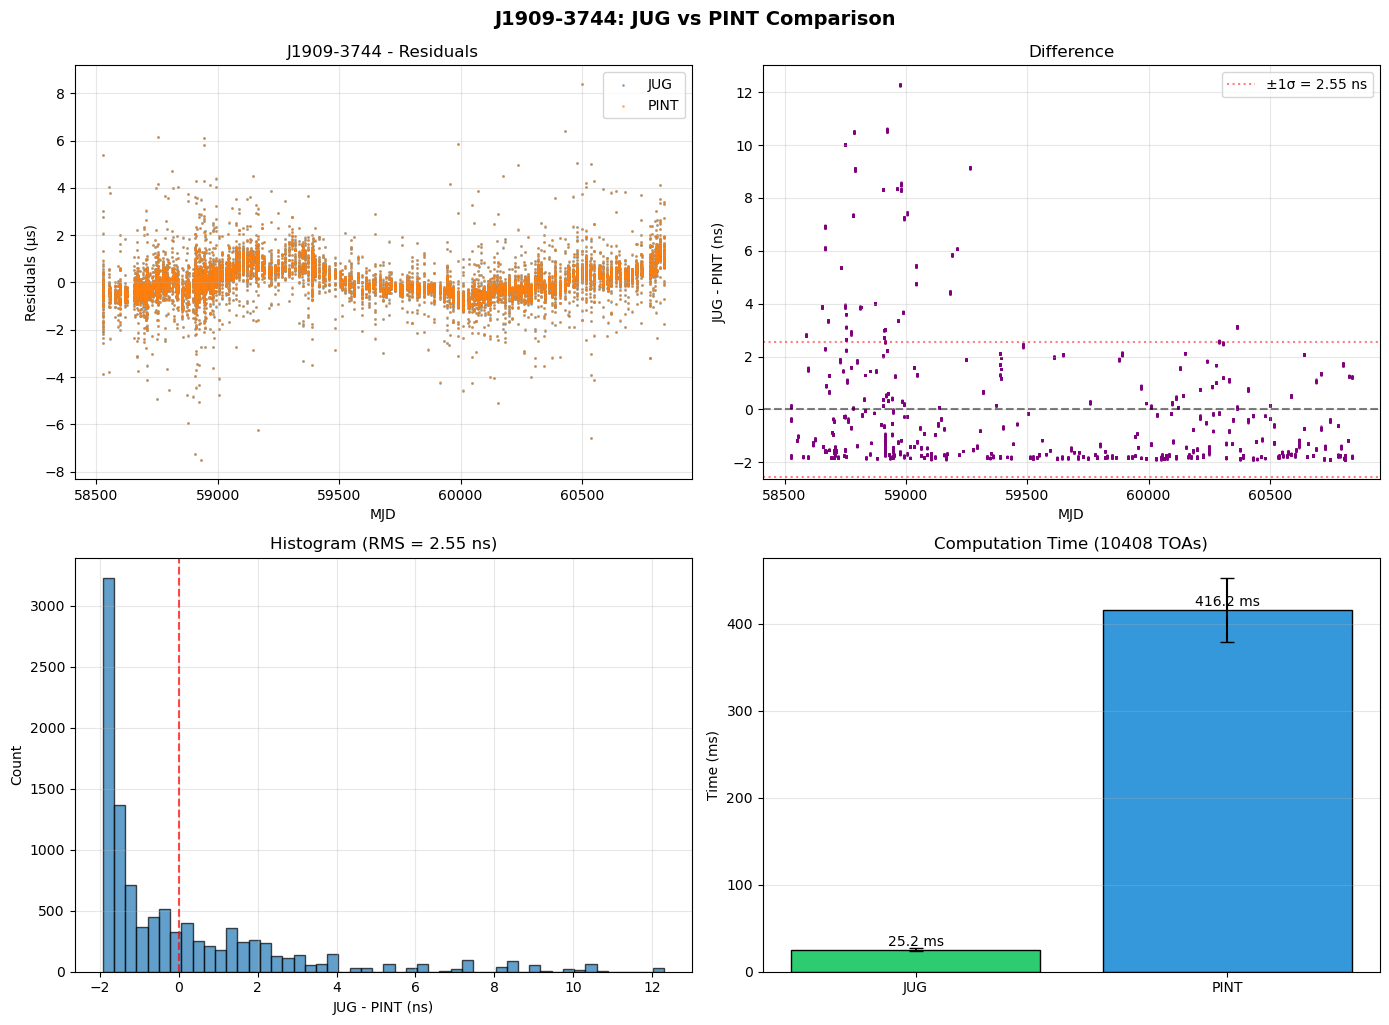

In [13]:
# === VISUALIZATION ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Residuals comparison
ax = axes[0, 0]
ax.scatter(mjd_float, jug_residuals_us, s=1, alpha=0.5, label='JUG')
ax.scatter(mjd_float, pint_residuals_us, s=1, alpha=0.5, label='PINT')
ax.set_xlabel('MJD')
ax.set_ylabel('Residuals (µs)')
ax.set_title(f'{PULSAR_NAME} - Residuals')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Difference
ax = axes[0, 1]
ax.scatter(mjd_float, diff_ns, s=1, alpha=0.5, c='purple')
ax.axhline(0, color='k', linestyle='--', alpha=0.5)
ax.axhline(np.std(diff_ns), color='r', linestyle=':', alpha=0.5, label=f'±1σ = {np.std(diff_ns):.2f} ns')
ax.axhline(-np.std(diff_ns), color='r', linestyle=':', alpha=0.5)
ax.set_xlabel('MJD')
ax.set_ylabel('JUG - PINT (ns)')
ax.set_title('Difference')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Histogram of differences
ax = axes[1, 0]
ax.hist(diff_ns, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(0, color='r', linestyle='--', alpha=0.7)
ax.set_xlabel('JUG - PINT (ns)')
ax.set_ylabel('Count')
ax.set_title(f'Histogram (RMS = {np.std(diff_ns):.2f} ns)')
ax.grid(True, alpha=0.3)

# Plot 4: Timing comparison
ax = axes[1, 1]
categories = ['JUG', 'PINT']
times_ms = [jug_mean_time * 1000, pint_mean_time * 1000]
errors_ms = [jug_std_time * 1000, pint_std_time * 1000]
colors = ['#2ecc71' if speedup > 1 else '#e74c3c', '#3498db']
bars = ax.bar(categories, times_ms, yerr=errors_ms, capsize=5, color=colors, edgecolor='black')
ax.set_ylabel('Time (ms)')
ax.set_title(f'Computation Time ({pint_toas.ntoas} TOAs)')
for bar, t in zip(bars, times_ms):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{t:.1f} ms', 
            ha='center', va='bottom', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.suptitle(f'{PULSAR_NAME}: JUG vs PINT Comparison', y=1.02, fontsize=14, fontweight='bold')
plt.show()

In [14]:
# === SUMMARY ===
print("="*70)
print("SUMMARY")
print("="*70)
print(f"""
Pulsar: {PULSAR_NAME}
TOAs:   {pint_toas.ntoas}

ACCURACY:
  RMS difference:  {np.std(diff_ns):.2f} ns
  Max difference:  {np.max(np.abs(diff_ns)):.2f} ns
  Drift:           {slope:.3f} ns/yr

SPEED:
  JUG:   {jug_mean_time*1000:.2f} ms
  PINT:  {pint_mean_time*1000:.2f} ms
  Speedup: {speedup:.1f}x {'(JUG faster)' if speedup > 1 else '(PINT faster)'}

Note: JUG currently uses PINT's TZR reference for exact phase matching.
The ~2.5 ns RMS difference comes from minor ephemeris/delay calculation differences.
""")

SUMMARY

Pulsar: J1909-3744
TOAs:   10408

ACCURACY:
  RMS difference:  2.55 ns
  Max difference:  12.30 ns
  Drift:           -0.347 ns/yr

SPEED:
  JUG:   25.21 ms
  PINT:  416.18 ms
  Speedup: 16.5x (JUG faster)

Note: JUG currently uses PINT's TZR reference for exact phase matching.
The ~2.5 ns RMS difference comes from minor ephemeris/delay calculation differences.

